# Example notebook for the usage of the SimCATS simulation class

This notebook gives an example for the simulation of charge stability diagrams (CSDs) using SimCATS. It is assumed, that SimCATS is already installed on the selected kernel.

## Imports

Import the required packages & modules

In [1]:
from simcats import Simulation, default_configs
from simcats.sensor import SensorPeakLorentzian, SensorGeneric
from simcats.support_functions import plot_csd
import numpy as np

DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


## Retrieve a default configuration

Default simulation configurations can be retrieved from the simulation module of SimCATS. In this example we will use the configuration "GaAs_v1". It contains a configuration of the ideal CSD structure, various types of distortions, and a configuration for the simulation of the sensor dot reaction.

In [2]:
config = default_configs["GaAs_v1"]

## Initialize an instance of the Simulation class using the retrieved config

Using the retrieved configuration, we will initialize an instance of the Simulation class. The configuration can be adjusted to other setups, or a completely new configuration can be created.

In [3]:
double_dot_device = Simulation(**config)

## Perform measurements

Now that we have initialized an instance of the Simulation class, we are ready to perform simulations of measurements. To perform measurements, we simply call the function `measure` and supply the desired voltage sweeps for (plunger) gates 1 & 2. As a result we get the measured CSD, the ground truth occupation of the dots, the ground truth lead transition mask, and the metadata of the measurement. The metadata contains the full configuration of the simulation object. As it is possible to f.e. set up distortions so that they are only included in a specified ratio/number of scans, the metadata is helpful to see if the distortion has been active in the scan. Additionally it is possible to allow distortion parameters to vary from scan to scan (to f.e. simulate noise fluctuations). For these cases the metadata also provides the last sampled parameters from the specified range. The metadata can also be used to intialize a new instance of the simulation class that has the same configuration as used for the current scan.

### 2D simulation

In this section we will exemplarily perform a simulation of a 2D measurement.

#### Perform a measurement of the full voltage range

For 2D simulations we simply call the function `measure` and supply the desired voltage sweeps for (plunger) gates 1 & 2. Additionally it is possible to supply a desired resolution. For 2D scans it is required that the resolution consists of two entries. One for the resolution along (plunger) gate 1 and one for the resolution along (plunger) gate 2 (Default is `np.array([100, 100])`). The resolution of both gates is not required to be identically. Distortions are typically defined in relation to swept voltage. The implemented distortions rescale their parameters to match the corresponding pixel resolution (pixel/volt). We will now first perform a scan over the full voltage space (defined by the volt_limits of the configuration). 

In [4]:
sweep_range_g1 = np.array([-0.2, -0.087])
sweep_range_g2 = np.array([-0.2, -0.047])
resolution = np.array([400, 400]) # first entry is (plunger) gate 1 resolution and second entry (plunger) gate 2 resolution

csd, occupations, lead_transitions, metadata = double_dot_device.measure(sweep_range_g1=sweep_range_g1,
                                                                         sweep_range_g2=sweep_range_g2,
                                                                         resolution=resolution)

#### Plot the results

Using the function `plot_csd` it is possible to plot the results of the simulation. It can be used for the CSD itself and also for the ground truth data.

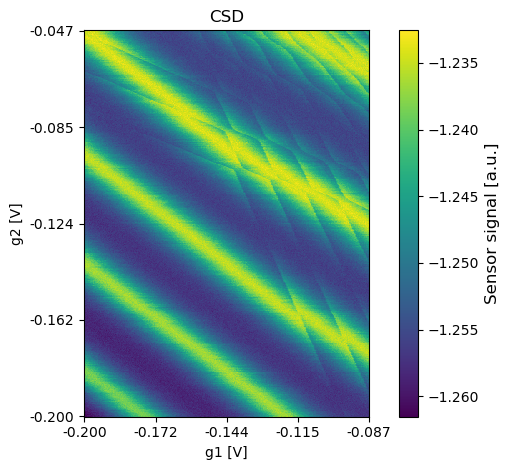

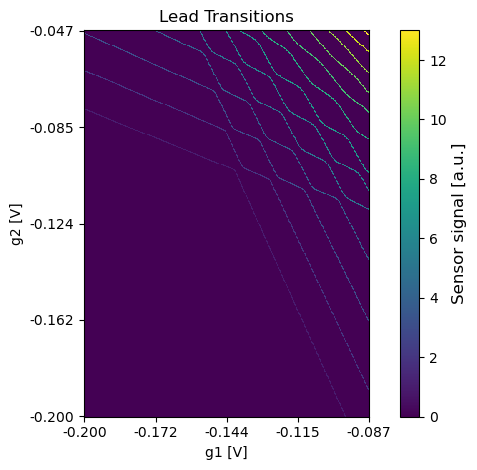

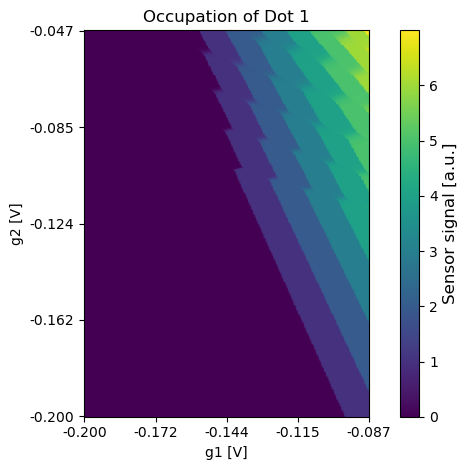

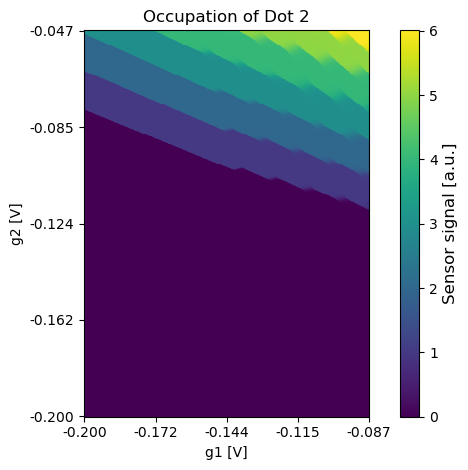

In [5]:
plot_csd(csd=csd, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="CSD")
plot_csd(csd=lead_transitions, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions")
plot_csd(csd=occupations[:,:,0], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 1")
plot_csd(csd=occupations[:,:,1], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 2")

### 2D simulation with a different sensor

In this section we will swap out the sensor configuration of the simulation instance. With the new sensor configuration we will then exemplarily perform a simulation of a 2D measurement.

#### Setup a new sensor and update the simulation configuration

We will now configure a new sensor, using Lorentzians to describe the Coulomb peaks. This sensor will then be used as new sensor for further simulations with the simulation instance. This allows to f.e. simulate the measurement of samples with multiple sensors. The sensor configuration that we will set up now assumes that the sensor is compensated (no influence by the two double dot (plunger) gates on the sensor potential). Therefore, alpha_gate will be set to zero for both gates. Additionally we will use only one Coulomb peak. Before changing to the new sensor, we will save the old sensor to be able to use it again.

In [6]:
old_sensor = double_dot_device.sensor

new_sensor = SensorGeneric(sensor_peak_function=[SensorPeakLorentzian(mu0=-0.10096, gamma=0.0011, height=0.029245, offset=-0.253275)],
                           alpha_dot=np.array([-0.0008, -0.0005]),
                           alpha_gate=np.array([0.0, 0.0]),
                           offset_mu_sens=-0.0988745)

double_dot_device.sensor = new_sensor

#### Perform a measurement

Using the new sensor we will repeat the 2D measurement from before.

In [7]:
sweep_range_g1 = np.array([-0.2, -0.087])
sweep_range_g2 = np.array([-0.2, -0.047])
resolution = np.array([300, 300]) # first entry is (plunger) gate 1 resolution and second entry (plunger) gate 2 resolution

csd, occupations, lead_transitions, metadata = double_dot_device.measure(sweep_range_g1=sweep_range_g1,
                                                                         sweep_range_g2=sweep_range_g2,
                                                                         resolution=resolution)

#### Plot the results

Using the function `plot_csd` it is possible to plot the results of the simulation. It can be used for the CSD itself and also for the ground truth data.

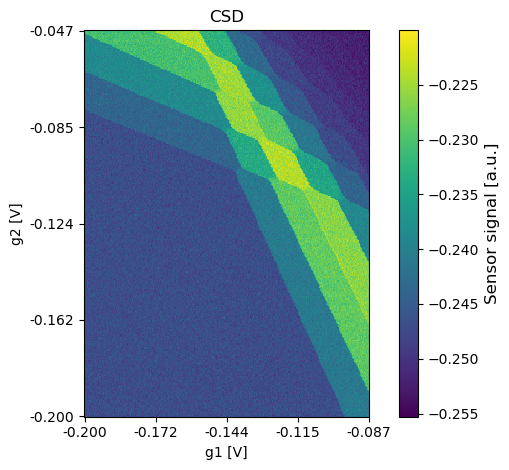

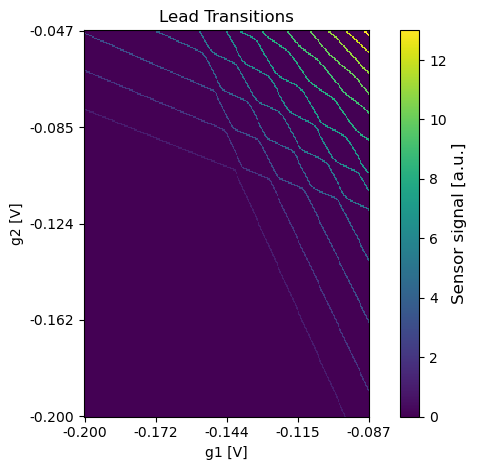

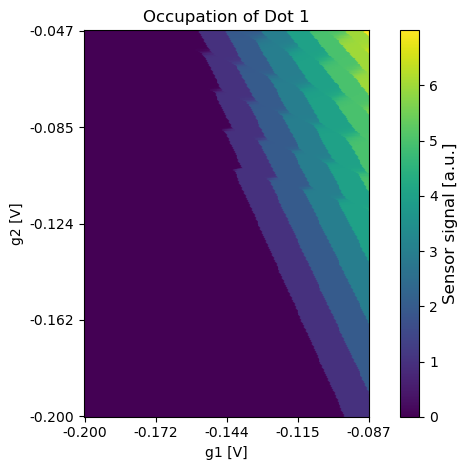

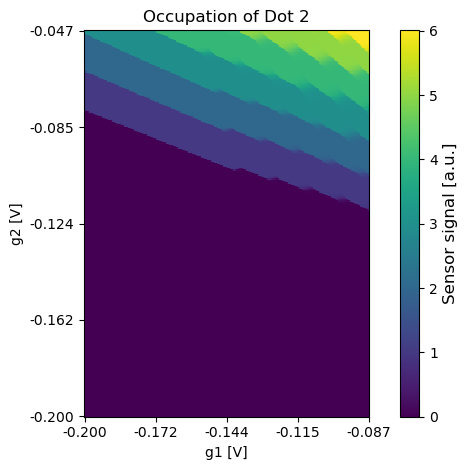

In [8]:
plot_csd(csd=csd, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="CSD")
plot_csd(csd=lead_transitions, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions")
plot_csd(csd=occupations[:,:,0], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 1")
plot_csd(csd=occupations[:,:,1], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 2")

### 2D Simulation of small regions (with the first/old sensor)

In this section we will reset the sensor configuration to the old sensor and perform a measurement of a small region in the voltage space.

#### Set the sensor configuration to the old sensor

In [9]:
double_dot_device.sensor = old_sensor

#### Perform a measurement

Using the old sensor we will now perform the measurement of a small region. This is assumed to be the kind of measurements that tuning algorithms will use.

In [10]:
sweep_range_g1 = np.array([-0.145, -0.125])
sweep_range_g2 = np.array([-0.11, -0.09])
resolution = np.array([100, 100]) # first entry is (plunger) gate 1 resolution and second entry (plunger) gate 2 resolution

csd, occupations, lead_transitions, metadata = double_dot_device.measure(sweep_range_g1=sweep_range_g1,
                                                                         sweep_range_g2=sweep_range_g2,
                                                                         resolution=resolution)

#### Plot the results

Using the function `plot_csd` it is possible to plot the results of the simulation. It can be used for the CSD itself and also for the ground truth data.

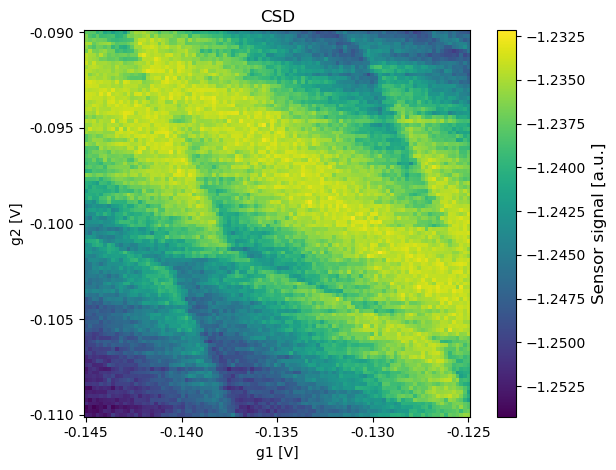

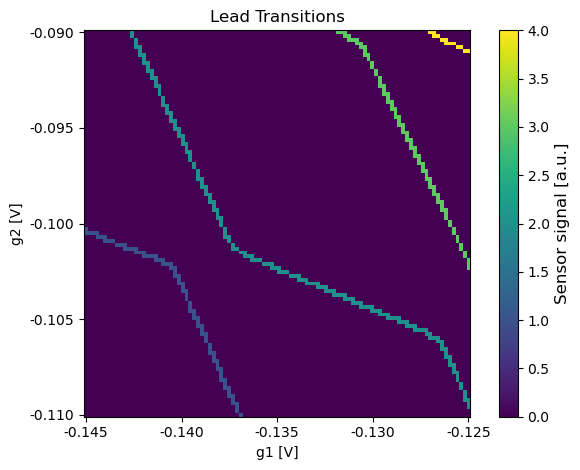

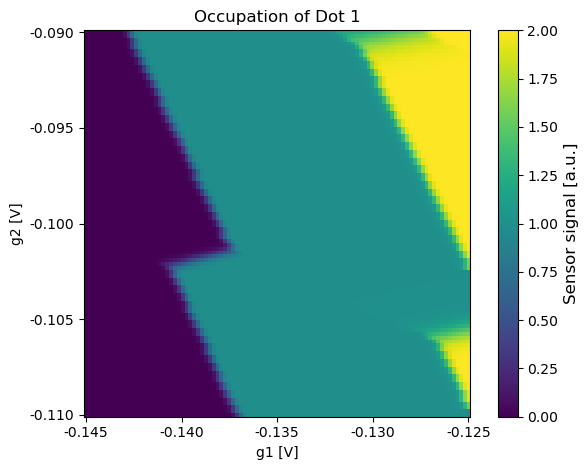

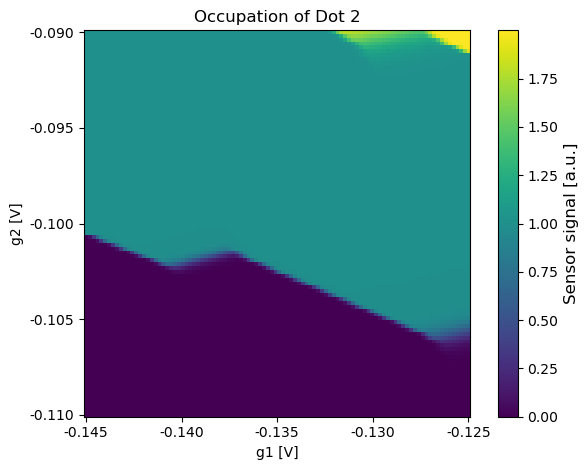

In [11]:
plot_csd(csd=csd, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="CSD")
plot_csd(csd=lead_transitions, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions")
plot_csd(csd=occupations[:,:,0], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 1")
plot_csd(csd=occupations[:,:,1], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 2")

### 1D simulation

In this section we will exemplarily perform a simulation of a 1D measurement.

#### Perform a measurement

For 1D simulations we can also use the the function `measure` that has been used for the 2D simulations. The only difference compared to a 2D measurement simulation is that we have to supply a single desired resolution, that will be used for sweeping both gates simulatenously. Nevertheless, the voltage range of both gates is not required to be identically. Distortions are typically defined in relation to swept voltage. The implemented distortions rescale their parameters to match the corresponding pixel resolution (pixel/volt).

In [12]:
sweep_range_g1 = np.array([-0.13, -0.11])
sweep_range_g2 = np.array([-0.09, -0.07])
resolution = np.array([300]) # both gates will be swept simultaneously resulting in the specified number of sampled pixels

csd, occupations, lead_transitions, metadata = double_dot_device.measure(sweep_range_g1=sweep_range_g1,
                                                                         sweep_range_g2=sweep_range_g2,
                                                                         resolution=resolution)

#### Plot the results

Using the function `plot_csd` it is possible to plot the results of the simulation. It can be used for the CSD itself and also for the ground truth data.

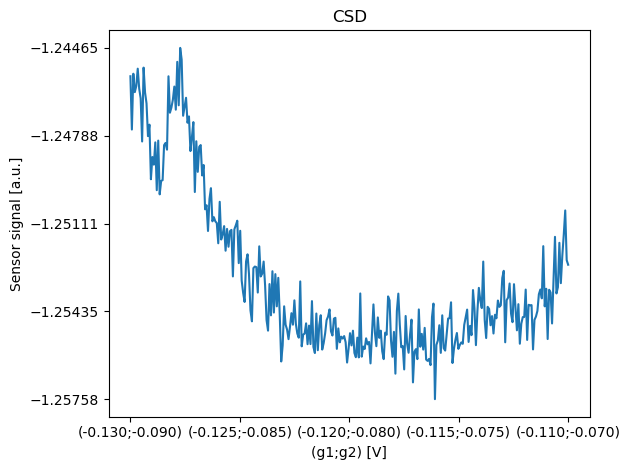

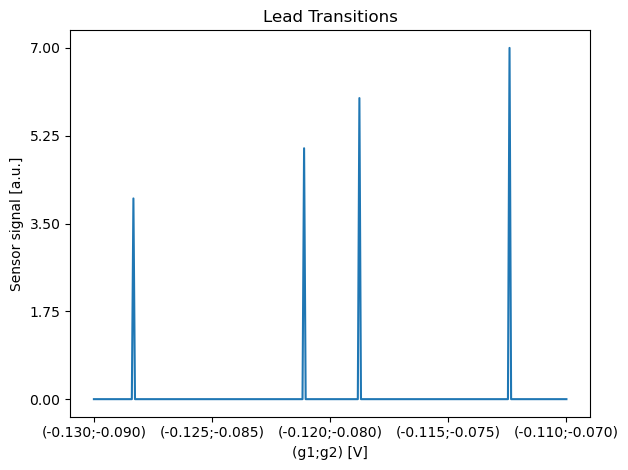

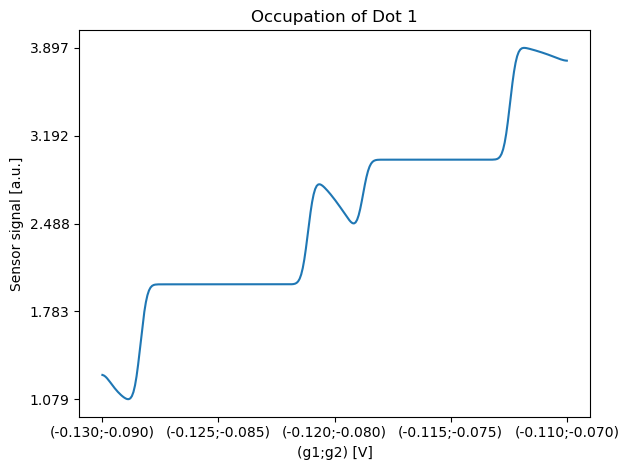

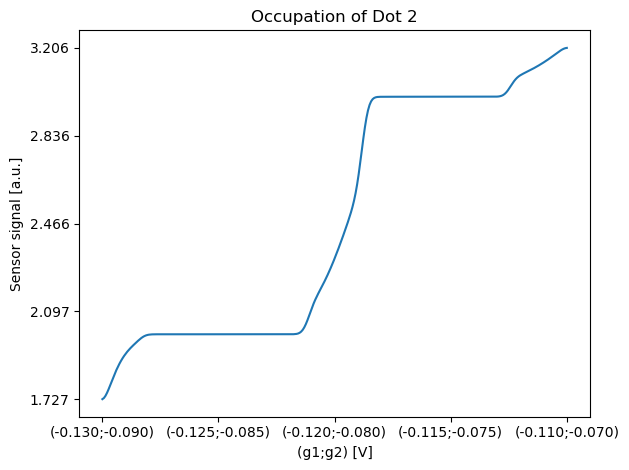

In [13]:
plot_csd(csd=csd, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="CSD")
plot_csd(csd=lead_transitions, volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Lead Transitions")
plot_csd(csd=occupations[:,0], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 1")
plot_csd(csd=occupations[:,1], volt_limits_g1=sweep_range_g1, volt_limits_g2=sweep_range_g2, title="Occupation of Dot 2")